# Segmented Strategy Optimization for S&P 500 and Stock Prediction Techniques


> Team members:Jieyi Wang, Weiqi He, Qin Liu



## Warm up in advance

In [1]:
########Load required Modules
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
######import functions
import torch.nn.functional as F
from torch.autograd import Variable
###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Preprocess dataset

In [3]:
# Train
dataset_train = pd.read_csv("dataset/train.csv")
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])
dataset_train = dataset_train[['Close']]
# Val
dataset_val = pd.read_csv("dataset/val.csv")
dataset_val['Date'] = pd.to_datetime(dataset_val['Date'])
dataset_val = dataset_val[['Close']]

### Test
dataset_test = pd.read_csv("dataset/test.csv")
dataset_test = dataset_test[['Close']]

### Use MinMaxScaler on close price

In [7]:
scaler_train = MinMaxScaler()
scaler_val = MinMaxScaler()
scaler_test = MinMaxScaler() ###
dataset_train_scaled = scaler_train.fit_transform(dataset_train.Close.values.reshape(-1,1))
dataset_val_scaled = scaler_val.fit_transform(dataset_val.Close.values.reshape(-1,1))
dataset_test_scaled = scaler_test.fit_transform(dataset_test.Close.values.reshape(-1,1)) ###

### Use a window of 20 days on close price

In [4]:
window = 21

In [8]:
x_train = []
y_train = []
for index in range(len(dataset_train_scaled) - window):
    need_data = dataset_train_scaled[index: index + window]
    x_train.append(need_data[:-1])
    y_train.append(need_data[-1])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [9]:
x_val = []
y_val = []
for index in range(len(dataset_val_scaled) - window):
    need_data = dataset_val_scaled[index: index + window]
    x_val.append(need_data[:-1])
    y_val.append(need_data[-1])
x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
####
x_test = []
y_test = []
for index in range(len(dataset_test_scaled) - window):
    need_data = dataset_test_scaled[index: index + window]
    x_test.append(need_data[:-1])
    y_test.append(need_data[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [11]:
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)

x_val_torch = torch.from_numpy(x_val).type(torch.Tensor)
y_val_torch = torch.from_numpy(y_val).type(torch.Tensor)
###
x_test_torch = torch.from_numpy(x_test).type(torch.Tensor)
y_test_torch = torch.from_numpy(y_test).type(torch.Tensor)

## LSTM stock price prediction

# Define a Net: LSTM



Ref: https://www.researchgate.net/publication/350950396_Introduction_to_Sequence_Learning_Models_RNN_LSTM_GRU

In [12]:
##### DEFINE LSTM net as described above:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
####### Hyperparameter
num_epochs = 200
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1

### Set the Loss & Optimizer

In [14]:
####### Declare a net
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

#######define LOSS and Optimizer
criterion = torch.nn.MSELoss(reduction='mean')
# optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)
####### show the net frame
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### Train the model

In [15]:
######## Train the model
model.train()
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_torch.to(device))
    loss = criterion(y_train_pred, y_train_torch.to(device))
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    #zero the parameter gradients
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
# torch.save(model, 'model.pth')
training_time = time.time() - start_time
print("Training time: {}".format(training_time))
print('Finished Training')

Epoch  0 MSE:  0.4159955382347107
Epoch  10 MSE:  0.053936392068862915
Epoch  20 MSE:  0.005732804536819458
Epoch  30 MSE:  0.00564899668097496
Epoch  40 MSE:  0.0023218118585646152
Epoch  50 MSE:  0.0009196336031891406
Epoch  60 MSE:  0.0006730845780111849
Epoch  70 MSE:  0.0005235171411186457
Epoch  80 MSE:  0.0005046093137934804
Epoch  90 MSE:  0.00048471178160980344
Epoch  100 MSE:  0.00046660550287924707
Epoch  110 MSE:  0.00046021619345992804
Epoch  120 MSE:  0.0004531132581178099
Epoch  130 MSE:  0.00044743751641362906
Epoch  140 MSE:  0.0004417587770149112
Epoch  150 MSE:  0.0004362001782283187
Epoch  160 MSE:  0.0004307529889047146
Epoch  170 MSE:  0.0004253801016602665
Epoch  180 MSE:  0.0004200656549073756
Epoch  190 MSE:  0.0004148013540543616
Training time: 363.0191879272461
Finished Training


### Evaluate the model

In [16]:
########Load pretrain model
final_model = torch.load('model.pth', map_location=torch.device('cpu'))
final_model

LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
########Evaluate model
final_model.eval()
y_train_model = scaler_train.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train_original = scaler_train.inverse_transform(y_train)


y_val_pred = final_model(x_val_torch.to(device))
y_val_model = scaler_val.inverse_transform(y_val_pred.detach().cpu().numpy())
y_val_original = scaler_val.inverse_transform(y_val)

y_test_pred = final_model(x_test_torch.to(device))
y_test_model = scaler_test.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test_original = scaler_test.inverse_transform(y_test)

### Model train result visualization

<Figure size 2560x1920 with 0 Axes>

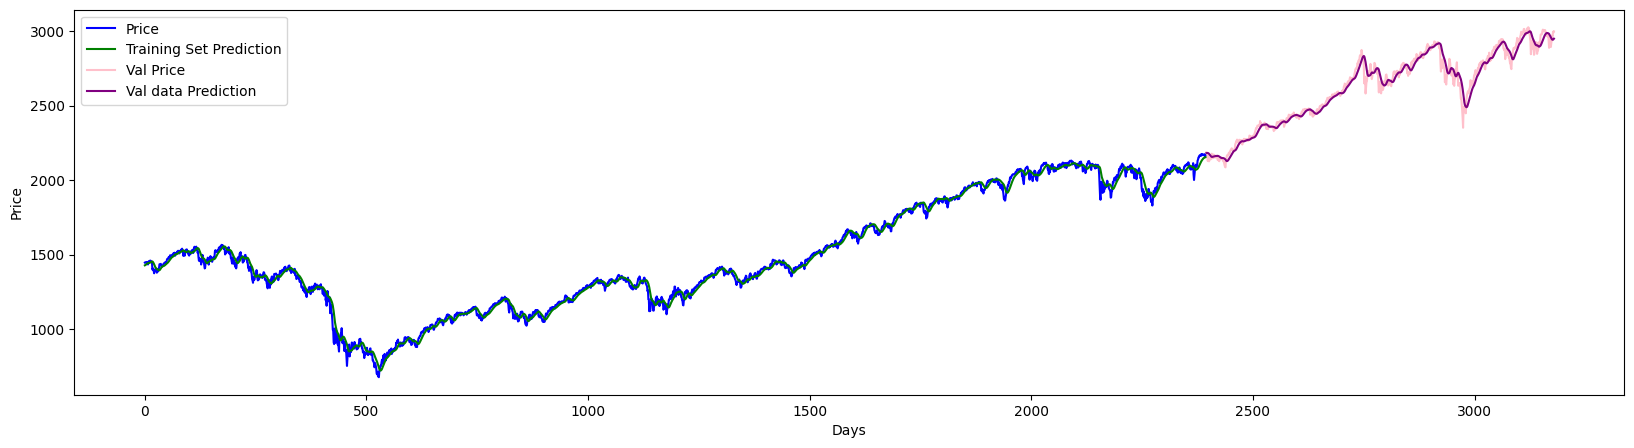

In [20]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 5))
plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Days')
plt.ylabel('Price')

plt.plot(index_val, y_val_original, color = 'pink', label = 'Val Price')
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
# plt.plot(index_test, y_test_original, color = 'red', label = 'test Price') ###
plt.legend()
plt.savefig("Val-Result1.png", dpi=500)
plt.show()
# df_LSTM_result = pd.DataFrame({'Original':y_val_original.flatten(),'Val Prediction':y_val_model.flatten()})
# df_LSTM_result.to_csv(r"Val-Result.csv",sep=',')

### Backtest
While backtesting the function, we also collect buying and selling points and the income of each trading operation.

In [22]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    """
    Backtest function to simulate trading based on the model's predictions.

    :param predictions: The predicted prices from the model.
    :param original_prices: The actual prices of the stock.
    :param threshold: The threshold for making a trade decision.
    :param initial_cash: The initial cash in the portfolio.
    :param buy_point: record buy point
    :paramsell_point: record sell point
    :paramfinance_info: Contains the cash and assert
    :return: The final portfolio value and the total return.
    """
    cash = initial_cash
    shares = 0
    total_assets = initial_cash
    buy_point = [0]*len(predictions)
    sell_point = [0]*len(predictions)
    finance_info = [[0]*2 for i in range(len(predictions))]


    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        # Decision to buy
        if predicted_change > threshold and cash >= original_prices[i]:
            shares_bought = cash // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]
            buy_point[i] = predictions[i]

        # Decision to sell
        elif predicted_change < -threshold and shares > 0:
            cash += shares * original_prices[i]
            shares = 0
            sell_point[i] = predictions[i]

        # Update total assets value
        total_assets = cash + shares * original_prices[i]
        finance_info[i][0]= cash
        finance_info[i][1]= total_assets
    total_return = total_assets - initial_cash
    return total_assets, total_return,buy_point,sell_point,finance_info

### The LSTM model prediction results enter the backtest system results

In [23]:
initial_cash = 500000
threshold = 0.015
buy_point = [0]*len(y_val_original[:, 0])
sell_point = [0]*len(y_val_original[:, 0])
finance_info = [[0]*2 for i in range(len(y_val_original[:, 0]))]
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return,buy_point,sell_point,finance_info = backtest(y_val_model[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 722989.9575195312 Total Return: 222989.95751953125 Return Rate: 44.59799150390625


In [ ]:
np.savetxt('val_original_LSTM.csv',y_val_original[:,0])
np.savetxt('finance_info_LSTM.csv',finance_info)
np.savetxt('buy_point_LSTM.csv',buy_point)
np.savetxt('sell_point_LSTM.csv',sell_point)

In [25]:
buy_point = [None if x == 0 else x for x in buy_point]
sell_point = [None if x == 0 else x for x in sell_point]

The trading income of each trading operation of the LSTM visual backtesting system

<Figure size 2560x1920 with 0 Axes>

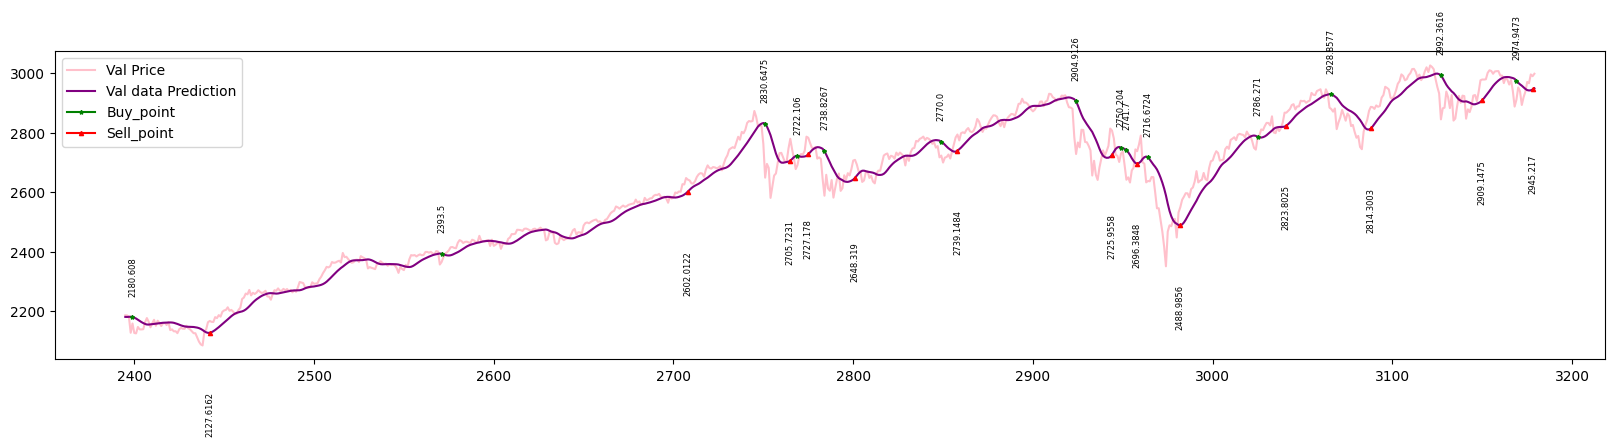

In [29]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 4))


plt.plot(index_val, y_val_original, color = 'pink', label = 'Val Price')
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, buy_point, color='green', label='Buy_point', marker='*', markersize=3)
plt.plot(index_val, sell_point, color='red', label='Sell_point', marker='^', markersize=3)
# plt.plot(index_test, y_test_original, color = 'red', label = 'test Price') ###
# 在每个标记上方标注值
offset = 350
font_size = 6  # 调整为适当的大小

for i, val in enumerate(buy_point):
    if val is not None:  # 只在值非None时添加文本
        plt.text(index_val[i], val +70, str(val), ha='center', va='bottom', rotation=90, fontsize=font_size)

for i, val in enumerate(sell_point):
    if val is not None:  # 只在值非None时添加文本
        plt.text(index_val[i], val - offset, str(val),ha='center', va='bottom',rotation=90, fontsize=font_size)

plt.legend()
plt.show()

### Original accurate prediction of stock price into backtesting system results

In [31]:
initial_cash = 500000
threshold = 0.015
buy_point = [0]*len(y_val_original[:, 0])
sell_point = [0]*len(y_val_original[:, 0])
finance_info = [[0]*2 for i in range(len(y_val_original[:, 0]))]
# Applying the backtest function to the Original's predictions
final_assets, total_return,buy_point,sell_point,finance_info = backtest(y_val_original[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 538882.6052246094 Total Return: 38882.605224609375 Return Rate: 7.776521044921875


In [32]:
np.savetxt('val_original.csv',y_val_original[:,0])
np.savetxt('finance_info_Original.csv',finance_info)
np.savetxt('buy_point_Original.csv',buy_point)
np.savetxt('sell_point_Original.csv',sell_point)

In [33]:
buy_point = [None if x == 0 else x for x in buy_point]
sell_point = [None if x == 0 else x for x in sell_point]

The original accurate stock price entered into the backtesting system and the trading profit for each trading operation

<Figure size 2560x1920 with 0 Axes>

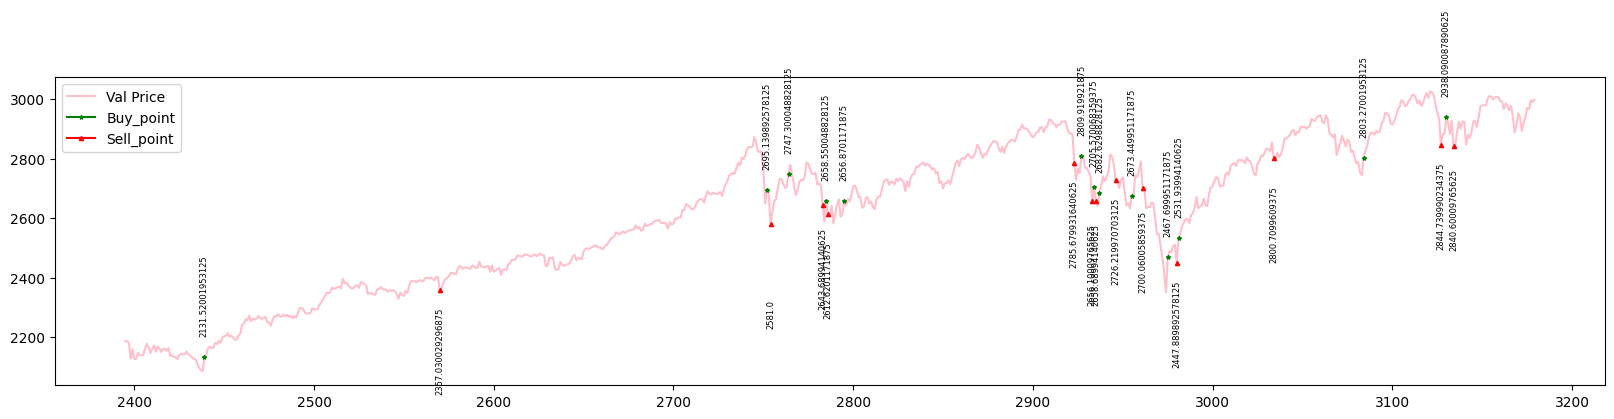

In [34]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 4))


plt.plot(index_val, y_val_original, color = 'pink', label = 'Val Price')
# plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, buy_point, color='green', label='Buy_point', marker='*', markersize=3)
plt.plot(index_val, sell_point, color='red', label='Sell_point', marker='^', markersize=3)
# plt.plot(index_test, y_test_original, color = 'red', label = 'test Price') ###
# 在每个标记上方标注值
offset = 350
font_size = 6  # 调整为适当的大小

for i, val in enumerate(buy_point):
    if val is not None:  # 只在值非None时添加文本
        plt.text(index_val[i], val +70, str(val), ha='center', va='bottom', rotation=90, fontsize=font_size)

for i, val in enumerate(sell_point):
    if val is not None:  # 只在值非None时添加文本
        plt.text(index_val[i], val - offset, str(val),ha='center', va='bottom',rotation=90, fontsize=font_size)

plt.legend()
plt.show()

## Adjust stock forecast price optimization strategy by segments



### segmented processing

In [35]:
import numpy as np

def model_process(data, threshold=0.05,segment=10):
    # sure data is np array
    data = np.array(data)
    n = len(data)
    segment_length = n // segment

    # process each segment
    for i in range(0, n, segment_length):
        segment = data[i:i + segment_length]
        if len(segment) == 0:
            break

        # cal change
        change = (segment[-1] - segment[0]) / segment[0] if segment[0] != 0 else 0

        # if change > threshold，set max
        if abs(change) > threshold:
            max_value = segment.max()
            data[i:i + segment_length] = max_value

    return data

### Select segmentation threshold

In [38]:
min_ = np.min(y_val_model)
max_ = np.max(y_val_model)
threshold_sg = (max_ - min_)/min_ * 0.2
segment = 4
y_seg_LSTM = model_process(y_val_model,threshold_sg,segment)

### LSTM segmentation strategy

In [39]:
initial_cash = 500000
threshold = 0.015
buy_point = [0]*len(y_val_original[:, 0])
sell_point = [0]*len(y_val_original[:, 0])
finance_info = [[0]*2 for i in range(len(y_val_original[:, 0]))]
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return,buy_point,sell_point,finance_info = backtest(y_seg_LSTM[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 737571.0388183594 Total Return: 237571.03881835938 Return Rate: 47.51420776367187


In [ ]:
np.savetxt('val_original_LSTM_seg.csv',y_val_original[:,0])
np.savetxt('finance_info_LSTM_seg.csv',finance_info)
np.savetxt('buy_point_LSTM_seg.csv',buy_point)
np.savetxt('sell_point_LSTM_seg.csv',sell_point)

In [40]:
buy_point = [None if x == 0 else x for x in buy_point]
sell_point = [None if x == 0 else x for x in sell_point]

The trading situation of LSTM based on segmented adjustment stock strategy entering the backtest system

<Figure size 2560x1920 with 0 Axes>

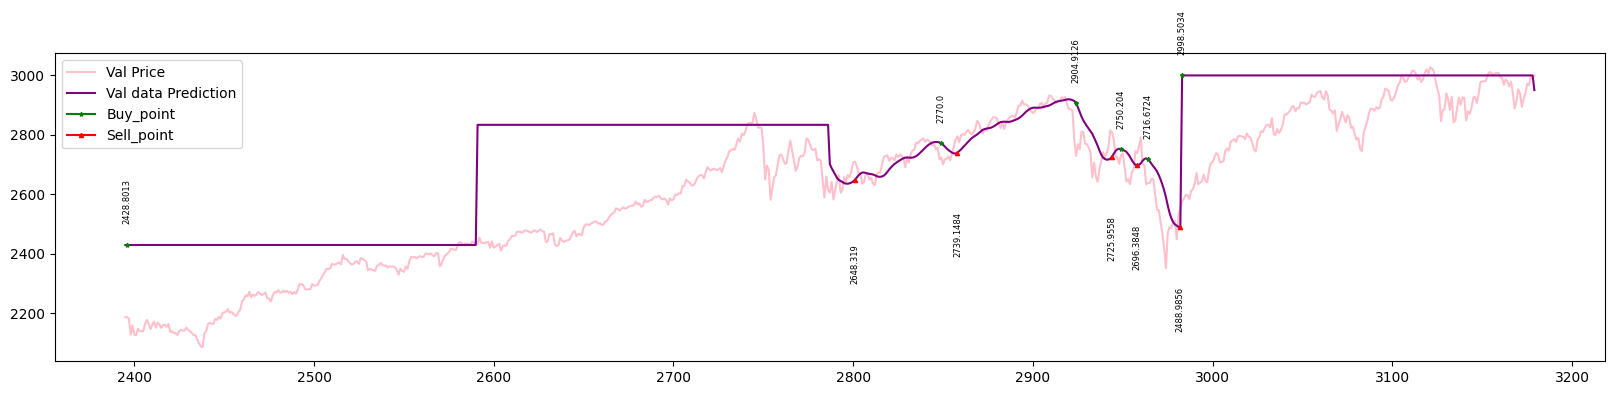

In [41]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 4))


plt.plot(index_val, y_val_original, color = 'pink', label = 'Val Price')
plt.plot(index_val, y_seg_LSTM, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, buy_point, color='green', label='Buy_point', marker='*', markersize=3)
plt.plot(index_val, sell_point, color='red', label='Sell_point', marker='^', markersize=3)
# plt.plot(index_test, y_test_original, color = 'red', label = 'test Price') ###

offset = 350
font_size = 6

for i, val in enumerate(buy_point):
    if val is not None:  # only when value is not none
        plt.text(index_val[i], val +70, str(val), ha='center', va='bottom', rotation=90, fontsize=font_size)

for i, val in enumerate(sell_point):
    if val is not None:  # only when value is not none
        plt.text(index_val[i], val - offset, str(val),ha='center', va='bottom',rotation=90, fontsize=font_size)

plt.legend()
plt.show()

### Segmentation strategies for raw accurate data

In [42]:
min_ = np.min(y_val_model)
max_ = np.max(y_val_model)
threshold_sg = (max_ - min_)/min_ * 0.2
segment = 4
y_seg_Original = model_process(y_val_original,threshold_sg,segment)

In [43]:
initial_cash = 500000
threshold = 0.015
buy_point = [0]*len(y_val_original[:, 0])
sell_point = [0]*len(y_val_original[:, 0])
finance_info = [[0]*2 for i in range(len(y_val_original[:, 0]))]
# Applying the backtest function to the LSTM model's predictions
final_assets, total_return,buy_point,sell_point,finance_info = backtest(y_seg_Original[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 590889.9172363281 Total Return: 90889.91723632812 Return Rate: 18.177983447265625


In [ ]:
np.savetxt('val_original_seg.csv',y_val_original[:,0])
np.savetxt('finance_info_original_seg.csv',finance_info)
np.savetxt('buy_point_original_seg.csv',buy_point)
np.savetxt('sell_point_original_seg.csv',sell_point)

In [44]:
buy_point = [None if x == 0 else x for x in buy_point]
sell_point = [None if x == 0 else x for x in sell_point]

The trading situation of the backtesting system based on the original accurate number of segment-adjusted stock strategies

<Figure size 2560x1920 with 0 Axes>

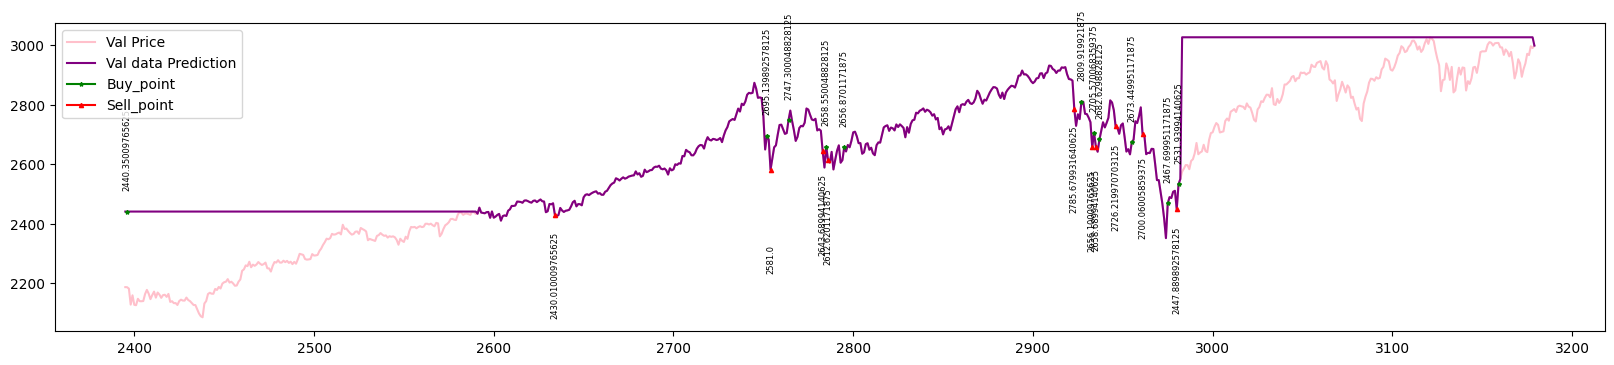

In [45]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

N_test = len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original
## Show all curve
plt.figure(dpi=400)
plt.figure(figsize=(20, 4))


plt.plot(index_val, y_val_original, color = 'pink', label = 'Val Price')
plt.plot(index_val, y_seg_Original, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, buy_point, color='green', label='Buy_point', marker='*', markersize=3)
plt.plot(index_val, sell_point, color='red', label='Sell_point', marker='^', markersize=3)
# plt.plot(index_test, y_test_original, color = 'red', label = 'test Price') ###

offset = 350
font_size = 6

for i, val in enumerate(buy_point):
    if val is not None:  #only when value is not none
        plt.text(index_val[i], val +70, str(val), ha='center', va='bottom', rotation=90, fontsize=font_size)

for i, val in enumerate(sell_point):
    if val is not None:  #only when value is not none
        plt.text(index_val[i], val - offset, str(val),ha='center', va='bottom',rotation=90, fontsize=font_size)

plt.legend()
plt.show()